# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import folium
from folium.plugins import FastMarkerCluster
from colour import Color

# Load dataset

In [2]:
df_brut = pd.read_csv('data/raw_2021.csv')
airports_code_brut = pd.read_csv('data/airport-codes.csv')

/Users/dam/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,6,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_brut.head(2)

,company,flight,auth_code,line_type,origin,destination,scheduled_dep,real_dep,scheduled_arr,real_arr,situation,jus_code
0,AZU,2497,0,N,SBMO,SBRF,NaN,NaN,2019-06-07 21:50:00,2019-06-07 21:39:00,REALIZADO,NaN
1,AZU,2493,0,N,SBMK,SBCF,NaN,NaN,2019-06-07 20:30:00,2019-06-07 20:30:00,REALIZADO,NaN


In [4]:
airports_code_brut.head(2)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"


# Clean datasets

## 0) quick view

In [5]:
df_brut

,company,flight,auth_code,line_type,origin,destination,scheduled_dep,real_dep,scheduled_arr,real_arr,situation,jus_code
0,AZU,2497,0,N,SBMO,SBRF,NaN,NaN,2019-06-07 21:50:00,2019-06-07 21:39:00,REALIZADO,NaN
1,AZU,2493,0,N,SBMK,SBCF,NaN,NaN,2019-06-07 20:30:00,2019-06-07 20:30:00,REALIZADO,NaN
2,AZU,2489,0,N,SBRF,SBGR,NaN,NaN,2019-06-07 23:35:00,2019-06-07 23:35:00,REALIZADO,NaN
3,AZU,2488,0,N,SBGR,SBRF,NaN,NaN,2019-06-07 08:20:00,2019-06-07 08:11:00,REALIZADO,NaN
4,AZU,2487,0,N,SBFL,SBKP,NaN,NaN,2019-06-07 17:45:00,2019-06-07 17:45:00,REALIZADO,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1592596,AZU,2503,0,N,SBPL,SBKP,NaN,NaN,2019-06-07 06:35:00,2019-06-07 06:31:00,REALIZADO,NaN
1592597,AZU,2502,0,N,SBRF,SBSG,NaN,NaN,2019-06-07 15:25:00,2019-06-07 15:05:00,REALIZADO,HD
1592598,AZU,2500,0,N,SBKP,SBPL,NaN,NaN,2019-06-08 02:35:00,2019-06-08 02:18:00,REALIZADO,HD
1592599,AZU,2499,0,N,SBJU,SBKP,NaN,NaN,2019-06-07 05:25:00,2019-06-07 05:09:00,REALIZADO,HD


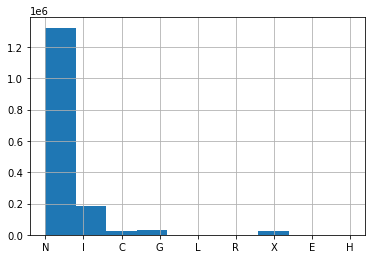

In [6]:
df_brut['line_type'].hist();

## 1) Drop useless columns

In [7]:
non_necessary_df = ['auth_code', 'scheduled_dep', 'real_dep', 'jus_code']

In [8]:
temp_df = df_brut.copy()
temp_df = temp_df.drop(labels=non_necessary_df, axis=1)

In [9]:
temp_airports_code = airports_code_brut.copy()

## 2) define columns type

### a) Datetime col

In [10]:
date_cols = ['scheduled_arr', 'real_arr']

for d in date_cols:
    temp_df[d] = pd.to_datetime(temp_df[d])
    
temp_df.head(2)

,company,flight,line_type,origin,destination,scheduled_arr,real_arr,situation
0,AZU,2497,N,SBMO,SBRF,2019-06-07 21:50:00,2019-06-07 21:39:00,REALIZADO
1,AZU,2493,N,SBMK,SBCF,2019-06-07 20:30:00,2019-06-07 20:30:00,REALIZADO


## 3) Delete some rows

### a) delete 'non realizado' flights

In [11]:
def n_rows_deleted(df_init, df_final):
    n_rows = abs(df_init.shape[0] - df_final.shape[0])
    print("{} rows have been deleted".format(n_rows))

In [12]:
temp_df = temp_df.loc[temp_df['situation'] == 'REALIZADO']
n_rows_deleted(df_brut, temp_df)

38309 rows have been deleted


### b) keep N and I flights

In [13]:
df_N = temp_df.loc[(temp_df['line_type'] == 'N')]
df_I = temp_df.loc[(temp_df['line_type'] == 'I')]

frames = [df_I, df_N]
temp_df = pd.concat(frames)

## 4) Delete outrange date 

In [14]:
def looking_for_dt(df):
    tmin = df['real_arr'].min()
    tmax = df['real_arr'].max()
    print("t min = {} \nt max = {}".format(tmin, tmax))

    dt = tmax - tmin
    print("dt = {}".format(dt))
    
    return tmin, tmax, dt

In [15]:
looking_for_dt(temp_df)

t min = 2017-10-21 09:35:00 
t max = 2021-07-01 07:55:00
dt = 1348 days 22:20:00


(Timestamp('2017-10-21 09:35:00'),
 Timestamp('2021-07-01 07:55:00'),
 Timedelta('1348 days 22:20:00'))

In [16]:
split_date = datetime.datetime(2021,8,1)
temp_df = temp_df.loc[temp_df['real_arr'] < split_date]

In [17]:
looking_for_dt(temp_df)

t min = 2017-10-21 09:35:00 
t max = 2021-07-01 07:55:00
dt = 1348 days 22:20:00


(Timestamp('2017-10-21 09:35:00'),
 Timestamp('2021-07-01 07:55:00'),
 Timedelta('1348 days 22:20:00'))

In [18]:
n_rows_deleted(df_brut, temp_df)

118732 rows have been deleted


## 5) Create new columns

### a) Year

In [19]:
temp_df['year'] = temp_df['real_arr'].dt.year

### b) Month

In [20]:
temp_df['month'] = temp_df['real_arr'].dt.month

### c) Hour

In [21]:
temp_df['hour'] = temp_df['real_arr'].dt.hour

### d) dt_arr_min

In [22]:
temp_df['dt_arr'] = (temp_df['scheduled_arr'] - temp_df['real_arr'])
temp_df['dt_arr_min'] = temp_df['dt_arr'] / np.timedelta64(1, 'm')
temp_df['delay'] = temp_df['dt_arr_min'].apply(lambda x : 'Late' if x<0 else 'Non Late')

### e) airports code : lat & long

In [23]:
temp_airports_code['long'] = temp_airports_code['coordinates'].str.split(',', expand=True)[0]
temp_airports_code['lat'] = temp_airports_code['coordinates'].str.split(',', expand=True)[1]

## 6) NaN values ?

In [24]:
temp_df.isna().sum()

company             0
flight              0
line_type           0
origin              0
destination         0
scheduled_arr    1706
real_arr            0
situation           0
year                0
month               0
hour                0
dt_arr           1706
dt_arr_min       1706
delay               0
dtype: int64

In [25]:
temp_df = temp_df.dropna()
temp_df.isna().sum()

company          0
flight           0
line_type        0
origin           0
destination      0
scheduled_arr    0
real_arr         0
situation        0
year             0
month            0
hour             0
dt_arr           0
dt_arr_min       0
delay            0
dtype: int64

## 7) prepare df for exploration

In [26]:
df = temp_df.copy()
airports_code = temp_airports_code.copy()
df_delay = df.loc[df['delay'] == 'Late']

# Exploration : The Delay

This part is focus on delayed flight. I'm trying to highlight some informations about delay by airports, companies, etc etc

## 1) Percentage of delayed flight

In [27]:
delayed_flight = df_delay.shape[0]
total_flight = df.shape[0]
p_delayed_flight = delayed_flight/total_flight

print('percentage of delayed flight = {:.0%}'.format(p_delayed_flight))

percentage of delayed flight = 26%


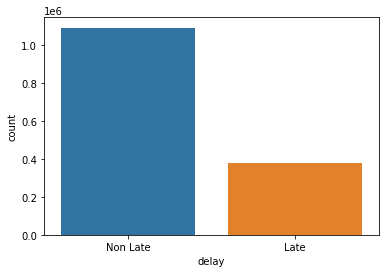

In [28]:
sns.countplot(x='delay', data=df);

## 2) Statistics

### a) global

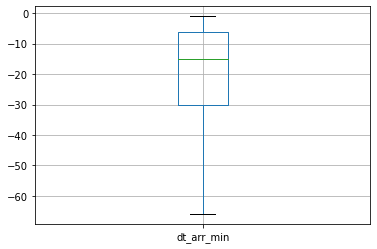

In [29]:
df_delay.boxplot(showfliers=False, column=['dt_arr_min']);

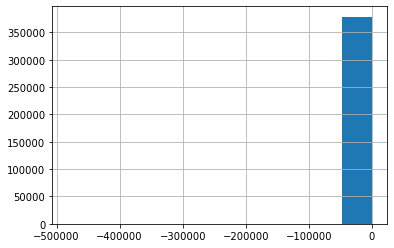

In [30]:
s_delay = df_delay['dt_arr_min']
s_delay.hist();

<AxesSubplot:>

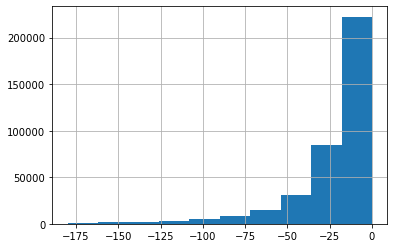

In [31]:
s_delay.hist(range=[-180,0])

### b) drop delay longer than 2 hours

In [32]:
df_delay_120 = df_delay[df_delay['dt_arr_min'] > -120]
p = df_delay_120.shape[0] / df_delay.shape[0]
print("{:.2%} of delayed flights are conserved".format(p))

96.88% of delayed flights are conserved


## 3) Delay by origin

In [33]:
def count_sum_by(df, criteria, colmn):
    s_sum = df[criteria].groupby(df[colmn]).sum()
    s_count = df[criteria].groupby(df[colmn]).count()
    s_sum_count = s_sum/s_count
    
    frame = {
        'sum_delay' : s_sum,
        'count_delay' : s_count,
        'ratio_sum_count' : s_sum_count 
    }
    
    df_count_sum = pd.DataFrame(frame)
    
    return df_count_sum

In [36]:
df_delay_origin = count_sum_by(df_delay_120, 'dt_arr_min', 'origin')

In [37]:
n = 20
df_delay_origin = df_delay_origin.sort_values(by=['count_delay'], ascending=False)
worst_10_origin = df_delay_origin[:n]

### map

#### add lat and long

In [38]:
# Extract lat and long
cols = ['ident', 'name', 'long', 'lat']
t_df = pd.DataFrame()

for idx, airport in enumerate(worst_10_origin.index):
    r = airports_code.loc[airports_code['ident']==airport]
    t_df = t_df.append(r[cols])

In [39]:
worst_10_origin = worst_10_origin.join(t_df.set_index('ident'))

#### show

In [40]:
def map_airports(df, c1, c2):
    n = df.shape[0]
    red = Color(c1)
    colors = list(red.range_to(Color(c2),n))

    m = folium.Map(location=(-12.109923,-57.8987643), zoom_start=4.32)

    for i,a in enumerate(df.index):
        r = df.iloc[i]
        lat = r['lat']
        long = r['long']
        lbl = "{:.0f} min".format(r['ratio_sum_count'])
        c = str(colors[i])

        folium.Marker(
        location=[lat, long],
        popup=lbl,
        icon=folium.Icon(color="white" ,icon_color=c, icon="info-sign"),
        ).add_to(m)
        
    return m

In [41]:
worst_10_origin = worst_10_origin.sort_values(by=['ratio_sum_count'], ascending=False)
map_airports(worst_10_origin, 'orange', 'red')

## 4) Delay by destination

In [42]:
df_delay_dest = count_sum_by(df_delay_120, 'dt_arr_min', 'destination')
n = 20
df_delay_dest = df_delay_dest.sort_values(by=['count_delay'], ascending=False)
worst_10_dest = df_delay_dest[:n]

In [43]:
cols = ['ident', 'name', 'long', 'lat']
t_df = pd.DataFrame()

for idx, airport in enumerate(worst_10_dest.index):
    r = airports_code.loc[airports_code['ident']==airport]
    t_df = t_df.append(r[cols])

worst_10_dest = worst_10_dest.join(t_df.set_index('ident'))

In [44]:
worst_10_dest = worst_10_dest.sort_values(by=['ratio_sum_count'], ascending=False)
map_airports(worst_10_dest, 'yellow', 'red')

## 5) Delay by airports

In [45]:
#df_airports = df_destination.add(df_origin, fill_value=0)
df_delay_airports = df_delay_dest.add(df_delay_origin, fill_value=0)
df_delay_airports['ratio_sum_count'] = df_delay_airports['sum_delay'] / df_delay_airports['count_delay']
df_delay_airports = df_delay_airports.sort_values(by='count_delay', ascending=False)
n=20
worst_10_airports = df_delay_airports.iloc[:n]

In [46]:
cols = ['ident', 'name', 'long', 'lat']
t_df = pd.DataFrame()

for idx, airport in enumerate(worst_10_airports.index):
    r = airports_code.loc[airports_code['ident']==airport]
    t_df = t_df.append(r[cols])

worst_10_airports = worst_10_airports.join(t_df.set_index('ident'))

In [47]:
worst_10_airports = worst_10_airports.sort_values(by=['ratio_sum_count'], ascending=False)
map_airports(worst_10_airports, 'yellow', 'red')

In [53]:
red = Color('red')
colors = list(red.range_to(Color('yellow'),n))

In [54]:
colors

[<Color red>,
 <Color #ff0d00>,
 <Color #ff1b00>,
 <Color #ff2800>,
 <Color #ff3600>,
 <Color #ff4300>,
 <Color #ff5100>,
 <Color #ff5e00>,
 <Color #ff6b00>,
 <Color #ff7900>,
 <Color #ff8600>,
 <Color #ff9400>,
 <Color #ffa100>,
 <Color #ffae00>,
 <Color #ffbc00>,
 <Color #ffc900>,
 <Color gold>,
 <Color #ffe400>,
 <Color #fff200>,
 <Color yellow>]